In [1]:
from PIL import Image
import numpy as np
import os

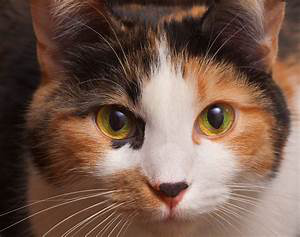

In [2]:
#store in cat1 and show sample cat image
from IPython.display import display

cat = Image.open("raw-img/cat/1013.jpeg")
display(cat)

In [3]:
#convert image into np and view shape
cat_np = list(cat.getdata())
np.shape(cat_np)

(71100, 3)

In [4]:
type(cat_np[0][0])

int

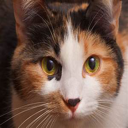

In [5]:
#test resize
stdSize = (128,128)
cat_std = cat.resize(stdSize)
display(cat_std)

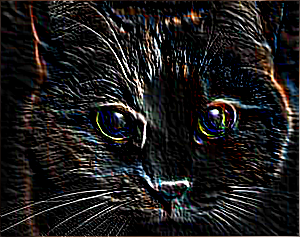

In [6]:
#test edge detection convolution
#Intuitively, consider the kernel
#-1 0 1
#-2 0 2
#-1 0 1
#when multiplied to image, if region is similar, output 0. If at boundary, will produce non-zero value.

#What I did here was combine the above kernel with horizontal version of same thing, and aggregate it.

from PIL import ImageFilter
cat_edge = cat.filter(ImageFilter.Kernel((3,3),( -2,-2,0,
                                                 -2, 0,2,
                                                  0, 2,2),1))
display(cat_edge)

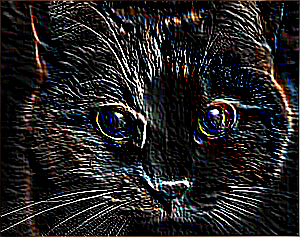

In [7]:
from PIL import ImageEnhance
cat_edge = ImageEnhance.Sharpness(cat_edge).enhance(3)
display(cat_edge)


Full preprocessing pipeline

In [8]:
aniList = ["cat", "cow", "butterfly"]
aniCount = np.zeros(len(aniList)).astype(np.uint)

cd = os.getcwd()
impath = os.path.join(cd, 'raw-img')
pcpath = os.path.join(cd, 'processed-img')

for a in aniList:
    os.makedirs(os.path.join(pcpath, a), exist_ok = True)

stdSize = (64,64)
for i, a in enumerate(aniList):
    extractPath = os.path.join(impath, a)
    savePath = os.path.join(pcpath, a)
    for file in os.listdir(extractPath):
        if file.endswith(".jpeg") or file.endswith(".jpg"): 
            im = Image.open(os.path.join(extractPath, file)).resize(stdSize).convert('L')
            im.save(os.path.join(savePath, str(aniCount[i])+'.png'))
            aniCount[i] += 1
        
print(aniCount)

[1667 1866 2072]


In [9]:
#Join first 1k image of each folder into numpy array. (First we'll see how well PCA does)
#unsupervised learning
aggPath = os.path.join(pcpath, 'aggregate1k')
os.makedirs(aggPath, exist_ok = True)

base = 0
numImage = 1000
for a in aniList:
    extractPath = os.path.join(pcpath, a)
    for j in range(numImage):
        im = Image.open(os.path.join(extractPath, str(j)+'.png'))
        im.save(os.path.join(aggPath, str(base+j)+'.png'))
    base += numImage


In [10]:
nData = len(aniList)*numImage
X = np.zeros((nData, stdSize[0]*stdSize[1])) 

for i in range(nData):
    im = Image.open(os.path.join(aggPath, str(i)+'.png'))
    X[i] = np.array(im.getdata())

print(X)

[[ 66.  66.  68. ...  37.  51.  78.]
 [253. 253. 253. ...  17.  38.  55.]
 [242. 242. 242. ... 214. 212. 212.]
 ...
 [ 98.  93.  96. ... 108.  99. 100.]
 [135. 138. 147. ...   6.   6.   8.]
 [ 92.  86.  89. ... 143. 137. 139.]]


In [ ]:
#make each entry in [0,1] (normalization)
X = X/255
print(X)

In [12]:
#PCA
from sklearn.decomposition import PCA

pca = PCA(n_components = 20)
pca.fit(X)

pcaX = pca.transform(X)[:,:2]
pcaX.shape

(3000, 2)

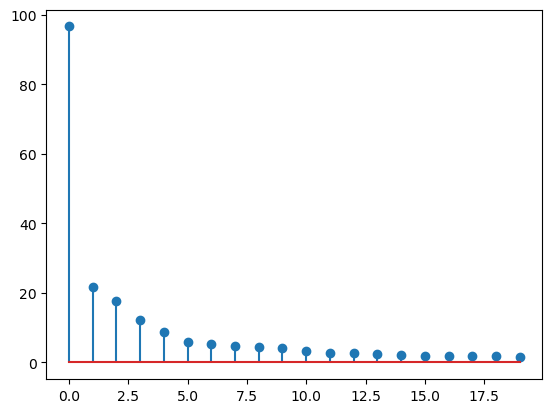

In [15]:
#stemplot of leading eigenvalues (data variance explanation plot)
from matplotlib import pyplot as plt

plt.figure()
plt.stem(pca.explained_variance_)
plt.show(0)

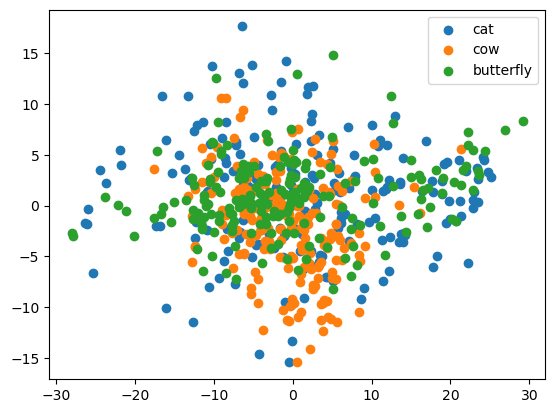

In [20]:
pcaX0_cat = pcaX[:1000:5,0]
pcaX1_cat = pcaX[:1000:5,1]

pcaX0_cow = pcaX[1000:2000:5,0]
pcaX1_cow = pcaX[1000:2000:5,1]

pcaX0_but = pcaX[2000::5,0]
pcaX1_but = pcaX[2000::5,1]

plt.figure()
plt.scatter(pcaX0_cat, pcaX1_cat)
plt.scatter(pcaX0_cow, pcaX1_cow)
plt.scatter(pcaX0_but, pcaX1_but)

plt.legend(('cat', 'cow', 'butterfly'))
plt.show()

#### Conclusion
Basic unsupervised learning techniques won't work. the features of 3 categories are not linearly separable at all.

Returning to our dataset $X$, we know that first 1k is cats, next 1k is cow and last 1k is butterfly. We can directly train CNN on this set without train-test split, as we can use the leftover dataset as validation. This time, we use 128x128 images for better feature extraction.

In [25]:
cd = os.getcwd()
impath = os.path.join(cd, 'raw-img')
pcpath = os.path.join(cd, 'cnn-img')

for a in aniList:
    os.makedirs(os.path.join(pcpath, a), exist_ok = True)

cnnImSize = (128,128)
aniCount = np.zeros(len(aniList), dtype = np.uint)
for i, a in enumerate(aniList):
    extractPath = os.path.join(impath, a)
    savePath = os.path.join(pcpath, a)
    for file in os.listdir(extractPath):
        if file.endswith(".jpeg") or file.endswith(".jpg"): 
            im = Image.open(os.path.join(extractPath, file)).resize(cnnImSize).convert('L')
            im.save(os.path.join(savePath, str(aniCount[i])+'.png'))
            aniCount[i] += 1

In [26]:
aggPath = os.path.join(pcpath, 'cnn_aggregate1k')
os.makedirs(aggPath, exist_ok = True)

base = 0
numImage = 1000
for a in aniList:
    extractPath = os.path.join(pcpath, a)
    for j in range(numImage):
        im = Image.open(os.path.join(extractPath, str(j)+'.png'))
        im.save(os.path.join(aggPath, str(base+j)+'.png'))
    base += numImage
    
nData = base

In [27]:
#create new data by 8 types of translation
translationList = [(1,0,16,0,1,0), (1,0,16,0,1,16), (1,0,0,0,1,16), (1,0,-16,0,1,16),
                  (1,0,-16,0,1,0), (1,0,-16,0,1,-16), (1,0,0,0,1,-16), (1,0,16,0,1,-16)]

IDX = nData
for i in range(nData):
    im = Image.open(os.path.join(aggPath, str(i)+'.png'))
    for translation in translationList:
        imShift = im.transform(cnnImSize, Image.AFFINE, translation)
        imShift.save(os.path.join(aggPath, str(IDX)+'.png'))
        IDX += 1

In [1]:
#since we already have stuff in all folders, we can start from this point.
from PIL import Image, ImageFilter
import numpy as np
import os

cd = os.getcwd()
impath = os.path.join(cd, 'raw-img')
pcpath = os.path.join(cd, 'cnn-img')

aniList = ['cat', 'cow', 'butterfly']

aggPath = os.path.join(pcpath, 'cnn_aggregate1k')

numImage = 1000
nData = 27000
cnnImSize = (128,128)

#Put data into CX & normalize
CX = np.zeros((nData*2, cnnImSize[0]*cnnImSize[1]), dtype = np.float16)

for i in range(nData):
    im = Image.open(os.path.join(aggPath, str(i)+'.png'))
    imfliplr = im.transpose(Image.FLIP_LEFT_RIGHT)
    CX[i] = np.array(im.getdata(), dtype = np.float16)
    CX[nData+i] = np.array(imfliplr.getdata(), dtype = np.float16)

CX = CX/255
print(CX)

[[0.306  0.251  0.2627 ... 0.2157 0.2627 0.3293]
 [0.996  0.996  0.996  ... 0.1765 0.1765 0.2864]
 [0.949  0.949  0.949  ... 0.8433 0.847  0.847 ]
 ...
 [0.     0.     0.     ... 0.     0.     0.    ]
 [0.     0.     0.     ... 0.5605 0.612  0.565 ]
 [0.     0.     0.     ... 0.6665 0.6743 0.6704]]


In [2]:
#First reshape CX to be suitable input into CNN
CX = np.reshape(CX, (len(CX), cnnImSize[0], cnnImSize[1]))
CX = np.expand_dims(CX, axis = 3)
print(CX.shape)

(54000, 128, 128, 1)


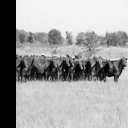

In [3]:
#Sample a datapt to check if stored correctly
np_test = CX[38000,:,:,0]
test = Image.fromarray(np.uint8(255*np_test), mode = 'L')
display(test)

In [4]:
#Create labels for CNN training
from tensorflow.keras.utils import to_categorical
nClass = len(aniList)
labelList = ([0]*numImage) + ([1]*numImage) + ([2]*numImage)
labelList += ([0]*numImage*8) + ([1]*numImage*8) + ([2]*numImage*8)
labelList *= 2
labels = to_categorical(labelList, num_classes = nClass)

In [5]:
#check labels
print(labels[0], labels[1000], labels[2000], labels[3000], labels[11000], labels[19000], len(labels))
print(labels[27000], labels[28000], labels[29000], labels[30000], labels[38000], labels[46000], len(labels))

[1. 0. 0.] [0. 1. 0.] [0. 0. 1.] [1. 0. 0.] [0. 1. 0.] [0. 0. 1.] 54000
[1. 0. 0.] [0. 1. 0.] [0. 0. 1.] [1. 0. 0.] [0. 1. 0.] [0. 0. 1.] 54000


In [6]:
#get some validation data into folder
valPath = os.path.join(pcpath, 'cnn_validation')

valIDX = 1000
numImage = 300
nData = 900

VX = np.zeros((nData, cnnImSize[0]*cnnImSize[1]), dtype = np.float16) 

for i in range(nData):
    im = Image.open(os.path.join(valPath, str(i)+'.png'))
    VX[i] = np.array(im.getdata(), dtype = np.float16)
    
VX = VX/255
VX = np.reshape(VX, (nData, cnnImSize[0], cnnImSize[1]))
VX = np.expand_dims(VX, axis = 3)
print(VX.shape)

vlabelList = np.array(([0]*numImage) + ([1]*numImage) + ([2]*numImage))
vlabels = to_categorical(vlabelList, num_classes = nClass)

(900, 128, 128, 1)


In [7]:
# get some final validation set into numpy (not used to check performance in training)
fvalPath = os.path.join(pcpath, 'cnn_final_validation')

fvalIDX = 1300
numImage = 300
nData = 900
    
FVX = np.zeros((nData, cnnImSize[0]*cnnImSize[1]), dtype = np.float16) 

for i in range(nData):
    im = Image.open(os.path.join(fvalPath, str(i)+'.png'))
    FVX[i] = np.array(im.getdata(), dtype = np.float16)
    
FVX = FVX/255
FVX = np.reshape(FVX, (nData, cnnImSize[0], cnnImSize[1]))
FVX = np.expand_dims(FVX, axis = 3)
print(FVX.shape)

fvlabelList = np.array(([0]*numImage) + ([1]*numImage) + ([2]*numImage))

(900, 128, 128, 1)


In [8]:
print(type(CX[0,0,0,0]), type(VX[0,0,0,0]), type(FVX[0,0,0,0]))

<class 'numpy.float16'> <class 'numpy.float16'> <class 'numpy.float16'>


In [9]:
#Import necessary packages to construct custom CNNs

#sequential CNN model, where data is passed in to clear feed-forward path
from tensorflow.keras.models import Sequential

#dense = hidden layer, dropout = regularizer, activation = non-linear function, flatten = 2D -> 1D
#convolution = user-defined convolution layers, maxpooling - feature dimension reduction layer
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPool2D

#backpropagation schemes
from tensorflow.keras.optimizers import SGD, Adam, RMSprop

#callback - earlystopping
from tensorflow.keras.callbacks import EarlyStopping

#backend - change datatype to float16
from tensorflow.keras.backend import set_floatx

In [10]:
#we now deploy a slightly complicated CNN to hopefully capture more
#the key change is the increase in filters & neurons, along with a regulization mechanism (dropout)
CNN = Sequential()

#default convolution has stride 1 and padding
#default pooling is (2,2) with stride = 2 and padding
CNN.add(Conv2D(16, (3,3), input_shape = CX[0].shape, activation = 'relu'))

CNN.add(Conv2D(32, (3,3), activation = 'relu'))
CNN.add(MaxPool2D())

CNN.add(Conv2D(64, (3,3), activation = 'relu'))
CNN.add(MaxPool2D()) ## think of removing?

CNN.add(Conv2D(64, (3,3), activation = 'relu'))
CNN.add(MaxPool2D()) ## think of removing?

CNN.add(Flatten())
CNN.add(Dense(400, activation = 'relu'))
CNN.add(Dropout(0.4))
CNN.add(Dense(nClass, activation = 'softmax'))

adam = Adam()
CNN.compile(optimizer = adam, loss = 'CategoricalCrossentropy', metrics = ['accuracy'])

In [11]:
CNN.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 16)      160       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 124, 124, 32)      4640      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 64)        0

In [ ]:
earlystop = EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 4, verbose = 1, restore_best_weights = True)

HIST = CNN.fit(CX, labels, batch_size = 540, epochs = 100, callbacks = [earlystop], 
               shuffle = True, validation_data = (VX, vlabels), verbose = 1)

Epoch 1/100
100/100 [==============================] - 2043s 20s/step - loss: 0.8404 - accuracy: 0.6031 - val_loss: 0.6351 - val_accuracy: 0.7456
Epoch 2/100
100/100 [==============================] - 2738s 27s/step - loss: 0.5141 - accuracy: 0.7947 - val_loss: 0.7146 - val_accuracy: 0.7278
Epoch 3/100
100/100 [==============================] - 1871s 19s/step - loss: 0.3854 - accuracy: 0.8500 - val_loss: 0.4443 - val_accuracy: 0.8222
Epoch 4/100
100/100 [==============================] - 1892s 19s/step - loss: 0.3081 - accuracy: 0.8827 - val_loss: 0.4430 - val_accuracy: 0.8300
Epoch 5/100
100/100 [==============================] - 1940s 19s/step - loss: 0.2499 - accuracy: 0.9051 - val_loss: 0.3841 - val_accuracy: 0.8533
Epoch 6/100
 27/100 [=======>......................] - ETA: 26:05 - loss: 0.2136 - accuracy: 0.9190

In [ ]:
labelFP = CNN.predict(FVX)
print('Accuracy of model on final validation is: ', sum(np.argmax(labelFP, axis = 1) == fvlabelList)/len(fvlabelList))

In [ ]:
#alright, let's take alook at what kind of image it classified correctly & incorrectly, and how much confidence..
right = np.squeeze(FVX[np.argmax(labelFP, axis = 1) == fvlabelList])
lright = labelFP[np.argmax(labelFP, axis = 1) == fvlabelList]

for i in range(0,len(right),10):
    np_im = np.reshape(right[i], cnnImSize)
    im = Image.fromarray(np.uint8(255*np_im), mode = 'L')
    print(np.max(lright[i]))
    display(im)

In [ ]:
wrong = np.squeeze(FVX[np.argmax(labelFP, axis = 1) != fvlabelList])
lwrong = labelFP[np.argmax(labelFP, axis = 1) != fvlabelList]
for i in range(len(wrong)):
    np_im = np.reshape(wrong[i], cnnImSize)
    im = Image.fromarray(np.uint8(255*np_im), mode = 'L')
    print(np.max(lwrong[i]), np.argmax(lwrong[i]))
    display(im)